##### Import wymaganych bibliotek

In [1]:
import os
import pandas as pd

import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.layers import Dense # głęboko połączona warstwa przekazująca neurony dalej (batch, size)
from tensorflow.keras.layers import Flatten # "spłaszcza" dane wejściowe, przekształca w 1wymiarową tablicę; nie wpływa na wielkość partii
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization #warstwa normalizująca dane wejściowe
from tensorflow.keras.layers import Dropout # odrzuca część losową informacji, gdy sieć wyciąga za dużo informacji
from tensorflow.keras.layers import LSTM # warstwa pamięci długookresowej (sztuczna rekurencyjna architektura sieci neuronowej RNN)
from tensorflow.keras.models import Model # grupuje warstwy w obiekt z funkacjami uczenia i wnioskowania
from tensorflow.keras.models import Sequential, load_model # do zaczytywania i wczytywania modelu
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from IPython.display import display # tworzymy obiekt audio 
import ipywidgets as widgets
from ipywidgets import interact, interact_manual # automatyczne tworzenie kontrolek interfejsu użytkownika  (user interface UI)
from ipywidgets import interactive

from sklearn.model_selection import train_test_split # dzielenie tablic lub macierzy na losowe podzbioru trenowania i testowania. 
from ipywidgets import interact, interact_manual
from ipywidgets import interactive
from sklearn.metrics import r2_score # R2- współczynnik determinacji; funkcja oceny regresji 
from sklearn.metrics import mean_absolute_error #MAE oraz MSE (błędy)
from sklearn.metrics import mean_squared_error


##### Import wymaganych bibliotek do stworzenia sieci LSTM

In [2]:
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler # przekształcanie cech skalując każdą z cech do określonego zakresu
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping # przerywa trenowanie, gdy monitorowana metryka przestanie się poprawiać; 
                                          # estymator ten skaluje i tłumaczy każdą cechę indywidualnie tak, że znajduje się ona w zadanym zakresie na zbiorze uczącym (np. między 0 a 1)
from keras.models import model_from_json

# 1. Model wersja I

Importowane są dane dotyczące spółki Amica, dla której przygotowywane będzie prognoza oraz pozostałych wybranych instrumentów do uczenia modelu:
1.	**Agora SA (AGO)** - badana spółka.
2.	Atlantis SE (ATS)
3.	Wojas SA (WOJ)
4.	Wawel SA (WWL)
5.	Sygnity SA (SGN)
6.	Fabryki Mebli Forte SA (FTE)
7.	Monnari Trade SA (MON)
8.	mBank SA (MBK)
9.	Comarch SA (CMR)
10.	CCC SA (CCC)
11.	Budimex SA (BDX)
12.	Fabryka Farb i Lakierów Śnieżka SA (SKA)
13.	Milkpol SA (MLP)

Poniżej przygotowywany jest plik .csv, który łączy wszystkie dane dotyczące akcji dla powyższych spółek w jednym pliku. 

In [3]:
main_data=pd.read_csv('dane//amc_d.csv', index_col='Data')

files=os.listdir('dane/')
files.remove('amc_d.csv')

for file in files:
    right=pd.read_csv('dane/'+file, index_col='Data', engine='python')
    
    main_data=main_data.merge(right=right,
                             how='inner',
                             left_index=True,
                             right_index=True,
                             copy=False,
                             suffixes=('','_'+file[:-4]))
main_data.to_csv('dane/rezultat.csv')
print(main_data.head())

            Otwarcie  Najwyzszy  Najnizszy  Zamkniecie  Wolumen  \
Data                                                              
2008-11-14    6.0804     6.0804     5.9049      6.0658  11938.0   
2008-11-17    6.0804     6.1023     5.9928      6.0292  14135.0   
2008-11-18    6.0658     6.0658     5.9269      5.9707  19157.0   
2008-11-19    5.9928     6.0220     5.8539      5.9707  13988.0   
2008-11-20    5.3788     5.8466     5.3788      5.8318  19615.0   

            Otwarcie_ago_d  Najwyzszy_ago_d  Najnizszy_ago_d  \
Data                                                           
2008-11-14          14.763           14.911           13.508   
2008-11-17          13.376           13.434           12.992   
2008-11-18          12.837           13.094           12.549   
2008-11-19          12.895           12.895           12.505   
2008-11-20          11.818           12.032           10.998   

            Zamkniecie_ago_d  Wolumen_ago_d  ...  Otwarcie_woj_d  \
Data         

## 1.1. Czyszczenie danych

Po usunięciu wartości NaN ilość wierszy zmniejszyła się jedynie o 1, co oznacza, że pobrane dane dotyczące akcji były bardzo dobrej jakości i nie zawierały błędnych/pustych rekordów. 

In [4]:
data = pd.read_csv('dane/rezultat.csv')
print('Dane przed usunięciem NaN: ', len(data), "Liczba kolumn: ", len (data.columns))
data['Zamkniecie'] = data['Zamkniecie'].shift(-1) #przesunięcie o 1 indeks, aby było o 1 dzień
data = data.dropna()
print('Dane po usunięciu NaN: ', len(data), "Liczba kolumn: ", len (data.columns))

Dane przed usunięciem NaN:  1245 Liczba kolumn:  71
Dane po usunięciu NaN:  1244 Liczba kolumn:  71


In [5]:
print(data.head())

         Data  Otwarcie  Najwyzszy  Najnizszy  Zamkniecie  Wolumen  \
0  2008-11-14    6.0804     6.0804     5.9049      6.0292  11938.0   
1  2008-11-17    6.0804     6.1023     5.9928      5.9707  14135.0   
2  2008-11-18    6.0658     6.0658     5.9269      5.9707  19157.0   
3  2008-11-19    5.9928     6.0220     5.8539      5.8318  13988.0   
4  2008-11-20    5.3788     5.8466     5.3788      5.9342  19615.0   

   Otwarcie_ago_d  Najwyzszy_ago_d  Najnizszy_ago_d  Zamkniecie_ago_d  ...  \
0          14.763           14.911           13.508            13.508  ...   
1          13.376           13.434           12.992            13.206  ...   
2          12.837           13.094           12.549            12.585  ...   
3          12.895           12.895           12.505            12.505  ...   
4          11.818           12.032           10.998            10.998  ...   

   Otwarcie_woj_d  Najwyzszy_woj_d  Najnizszy_woj_d  Zamkniecie_woj_d  \
0          3.5134           3.5134   

## 1.2. Statystyki opisowe

Poniżej zaprezentowano statystyki opisowe dla danych dotyczących akcji wybranych spółek. Jeśli chodzi o statystyki dotyczące badanej spółki Amica, można wymienić główne spostrzeżenia takie jak:

1. Średnia wartość "Zamknięcia" w dniu wynosiła 98,48.
2. 25% danych "Zamknięcia", czyli 311 wartości (0,25*1444) jest mniejsze lub równe 35,82, a 75% większe niż 35,82.
3. 75% wartości "Zamknięcia", czyli 1083 wartości (0,75*144) jest mniejsze niż 146,68, a tylko 25% jest większe niż 146,68.
4. Najmniejsza wartość "Zamknięcia" w badanym zbiorze danych dla spółki Amica wyniosła 2,34, a najwyższa 190,84.

In [6]:
data.describe() 
#przedstawić w sprawozdaniu:
#count ilość pojawień w ramach atrybutu: czyli dane po usunięciu NaN, wszędzie powinno być to samo
#mean średnia
#std odchylenie standardowe, im większe tym bardziej zmienna zmienna
#25%, 50%, 75% dystrybuanta, rozkład zmiennej - ciąg rosnący
#25% danych otwarcia ułożonych w ciągu rosnącym, czyli 25%*1244=311 ma wartość mniejsza lub równą 35,79

,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Wolumen,Otwarcie_ago_d,Najwyzszy_ago_d,Najnizszy_ago_d,Zamkniecie_ago_d,Wolumen_ago_d,...,Otwarcie_woj_d,Najwyzszy_woj_d,Najnizszy_woj_d,Zamkniecie_woj_d,Wolumen_woj_d,Otwarcie_wwl_d,Najwyzszy_wwl_d,Najnizszy_wwl_d,Zamkniecie_wwl_d,Wolumen_wwl_d
count,1244.000000,1244.00000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1.244000e+03,...,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000
mean,98.486417,99.50725,97.165948,98.571143,12517.061093,11.227732,11.380294,11.049347,11.221038,6.375823e+04,...,5.077736,5.148802,4.989980,5.093038,5314.951768,718.424252,725.661326,710.679855,719.110410,778.524116
std,53.474615,53.88474,52.864159,53.333998,27178.127858,3.828793,3.865185,3.786973,3.829569,1.289514e+05,...,1.175818,1.190637,1.156681,1.173875,10289.043970,283.304782,286.538446,280.067873,283.555016,2277.132638
min,2.389900,2.45560,2.338600,2.389900,167.000000,4.560000,4.590000,4.310000,4.440000,1.700000e+01,...,2.686100,2.797100,2.413300,2.481400,1.000000,109.880000,110.620000,106.220000,110.330000,1.000000
25%,35.799750,36.14025,35.337000,35.822000,2403.000000,8.656025,8.757900,8.476925,8.676725,8.544250e+03,...,4.330875,4.391700,4.239525,4.329775,765.250000,462.310000,467.422500,460.492500,464.710000,65.000000
50%,99.715000,100.97500,97.580000,99.507000,4787.000000,10.183000,10.323000,10.079500,10.220500,2.471750e+04,...,4.931500,4.979400,4.856350,4.950650,2291.500000,801.095000,806.750000,795.075000,803.480000,185.500000
75%,146.400000,147.63000,144.682500,146.202500,11989.500000,13.297000,13.434000,13.082500,13.296000,6.557100e+04,...,5.698425,5.798700,5.587700,5.715575,5131.750000,937.022500,946.290000,920.297500,937.397500,605.500000
max,191.560000,191.65000,189.050000,190.840000,492587.000000,21.421000,21.512000,21.248000,21.362000,1.786521e+06,...,8.480100,8.801100,8.393300,8.540900,125261.000000,1216.670000,1216.670000,1196.980000,1208.110000,39898.000000


In [7]:
x = data['Otwarcie']
mediana = np.median(x)
print(mediana)
# To samo co 50% powyżej

99.715


## 1.3. Analiza korelacji

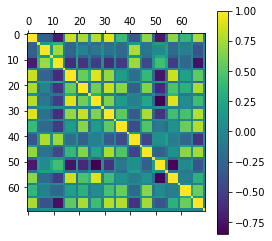

In [8]:
plt.matshow(data.corr()) #domyślnie Pearson
plt.colorbar()
# zależność liniowa między każdym parametrem 
# 140 kolumn - skala

# ! dodatkwo: wygenerować skalę kolorów, co znaczy jasny a co ciemny kolor
# jasny żółty- korelacja +1, a korelacja -1 to ciemne kolory

In [9]:
def plot_corr(df, size=10):
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)

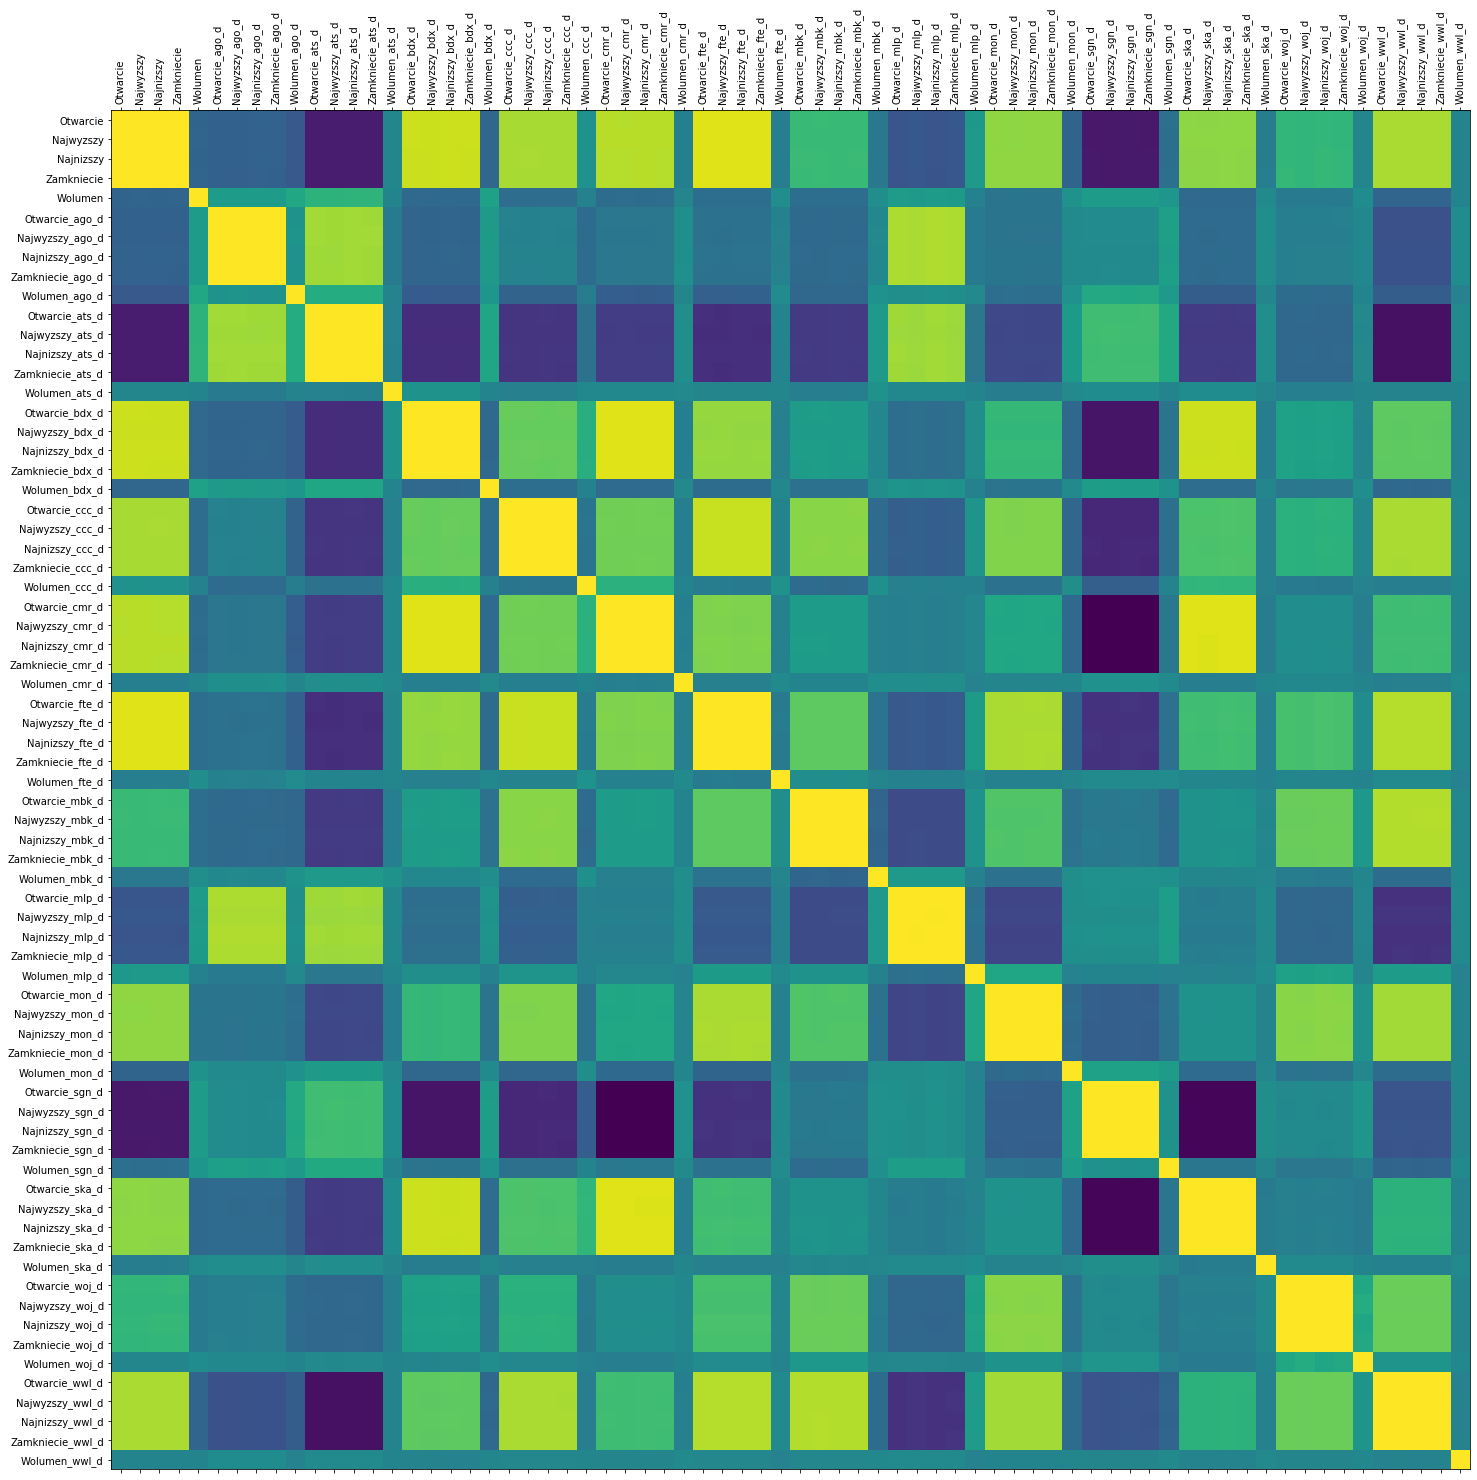

In [10]:
plot_corr(data, 25)
plt.savefig('korelacje.png')

In [11]:
corr = data.corr()
corr.style.background_gradient('Oranges')

In [12]:
corr.to_csv('plikzkorelacjami.csv')
#przeanalizować korelacje

**Podsumowanie:**
 
Ciekawe spostrzeżenia z analizy korelacji między spółkami:

**1.** Najwyższą korelację dodatnią dla zmiennej "Zamknięcie" dla spółki Amica (> 0,75) zaobserwować można między Budimex (BDX), CCC, Comarch SA (CMR), Fabryka Mebli Forte (FTE) oraz Wawel (WWL). Wynikać to może z faktu, iż wszystkie te spółki są dużymi przedsiębiorstwami, które generują duże przychody, a co za tym idzie ich akcje osiągają podobnie wysokie wartości. Tym samym, reagują na zachowania rynkowe w podobny sposób.

**2.** Dużą korelację ujemną zaobserwować można dla społek Comarch i Sygnity. Oznacza to, że inwestorzy są skłonni inwestować więcej w duże i bezpieczne spółki, przez co spada popyt na akcje mniejszych spółek, co generuje ujemną korelację. 
    

## 1.4. Przygotowanie modelu

Poniżej stworzone zostały funkcje, które przygotowują dane do dalszej pracy z modelem. Dane są przeskalowywane na wartości od 0 do 1. Dane wejściowe oznaczane są zmienną X, natomiast dane wyjściowe jako Y. Aby "zapanować" nad procesem uczenia losowo wybierane są rekordy do zbiorów testowych i uczących. W drugiej części klasy zabezpieczane są podziały danych (batch), tak aby dane testowe i treningowe nie zawierały tych samych rekordów. Tworzone są zbiory: uczący oraz testowy w proporcji 0,67 i 0,33. 
Krok czasowy w batchu to 7 dni. 

In [13]:
from sklearn.preprocessing import MinMaxScaler

class BatchedData():
    from sklearn.preprocessing import MinMaxScaler # zdefiniować dane wyjściowe, wejściowe, treningowe i testowe
    #minmax przesaklowanie danych od 0 do 1
    def __init__(self,data,num_days,scaler=MinMaxScaler()): #self zmienna globalna w każdej metodzie klasy
        self.scaler = scaler #data zbiór danych
        self.data = data
        self.num_days = num_days #num days do zdefiniowania ilosci dni historycznych indeksów, paczkujemy w próbki danych, założyliśmy że to 7 dni
        
        
        #ogólnie zmienne z literą "X" dotyczą zbioru wejściowego, natomiast z literą "Y" dotyczą zbioru wyjściowego
        # X wejście Y wyjście
        #fit do wyanczenia sredniej  i odchylenia
        #transform wyznaczenie pochodnej
        #predykcja zamkniecia danego indeksu
        self.X = self.scaler.fit_transform(self.data.drop(columns=['Data','Zamkniecie']))#normalizacja danych i usunięcie kolumn, które nie mają być danymi wejściowymi
        self.y = self.data['Zamkniecie'].values/np.max(self.data['Zamkniecie'])#wartość kolumny "Zamknięcie" jest prognozowana na wyjściu sieci
        # wyznaczamy zawsze wartosc 1 lub mniejsza
        
       #zapanowanie nad procesem uczenia
        self.rng = np.random.randint(1,len(self.data)-self.num_days)#losowe wybieranie rekordów do zbiorów testowych i uczących
        self.x_batch = self.X[self.rng:self.rng+self.num_days,:]
        self.y_batch = self.y[self.rng-1]
        
        
        #2czesc: sluzy do zabezpieczenia podziału danych w ten sposób że dane testowe i treningowe
        #nie beda zawierały tych samych rekordow
        # nie uwzgledniamy podziału zmiennych w czasie
    def nextBatch(self):
        rng = np.random.randint(1,len(self.data)-self.num_days)
        
        while(True):
            rng = np.random.randint(1,len(self.data)-self.num_days)
            
            if rng != self.rng:
                self.rng = rng
                break
                
        self.x_batch = self.X[self.rng:self.rng+self.num_days,:].reshape([self.num_days,self.X.shape[1]])#wyznaczamy ilosc kolumn [1]
        self.y_batch = self.y[self.rng-1]
        
        #dzielimy dane na treningowe i testowe:
        #3 zbiory: uczacy i testowy
    def createDataset(self):
        train_range = int(len(self.data) * 0.67)# zbiór uczący/treningowy
        test_range = int(len(self.data) * 0.33)#zbiór testowy
        
        self.X_train = np.zeros([train_range,num_days,self.X.shape[1]]) #3wymiarowa macierz
        self.Y_train = np.zeros([train_range])#

        for i in range(train_range):
            self.nextBatch()
            self.X_train[i,:,:] = self.x_batch
            self.Y_train[i] = self.y_batch

        self.X_test = np.zeros([test_range,num_days,self.X.shape[1]])
        self.Y_test = np.zeros([test_range])

        for i in range(test_range):
            self.nextBatch()
            self.X_test[i,:,:] = self.x_batch
            self.Y_test[i] = self.y_batch

Poniżej wywoływana jest funkcja tworząca zbiór danych do modelu. Widać, że w zbiorze testowym unikalnych wartości jest około 75% wszystkich wartości. Zastosowany krok czasowy to 7 dni historycznych.

In [14]:
num_days = 7 #liczba dni historycznych
batched_data = BatchedData (data, num_days)
batched_data.createDataset()#utworzony jest zbiór z danymi historycznymi

len(np.unique(batched_data.Y_test))
#len(np.unique(batched_data.Y_train))
#1244*0,67=833 - uczacy
#1244*0,33=410 - testowy
#ile jest unikalnych wartości jesli jest mniej jak 54% to mozna byc przeuczenie

327

Tworzona sieć, to sieć rekurencyjna o modelu sekwencyjnym. Jest to liniowym stos warstw. Model sekwencyjny można utworzyć, przekazując konstruktorowi listę instancji warstw. Stworzona sieć posiada 5 warstw. Każda z nich została utworzona z innymi paramterami. 
* Pierwsza warstwa posiada 77 neuronów. Przyjęto funkcję aktywacji ReLU. Jest to liniowe podejście, funkcja, która przyjmuje dowolne wartosci rzeczywiste, ale aktywuje się tylko wtedy gdy wejście jest większe od 0. Zastosowano współczynnik Dropout równy 0,5. Dropout to technika, w której losowo wybrane neurony są ignorowane podczas treningu celem przeciwdziałania przeuczeniu. Paramter ten oznacza, że co drugi (50%) wejść będzie losowo ignorowanych podczas aktualizacji etapu uczenia.
* Druga warstwa posiada 37 neuronów. Przyjęto funkcję aktywacji Softmax. Jest to funkcja prawdopodobieństwa, która normalizuje wynik wyjściowy podając go jako prawdopodobieństwo. Ich suma zawsze daje 1. Zastosownowo Dropout = 0.5.
* Trzecia warstwa posiada 24 neurony i funkcję aktywacji ReLU.
* Czwarta warstwa posiada 12 neuronów i również funkcję aktywacji ReLU. Dodatkowo zastosowano Dropout = 0.3.
* Piąta warstwa posiada 6 neuronów. Zastosowano funkcję aktywacji Sigmoid.
* Funkcja Flatten ma za zadanie przekonwertować macierz na wektor. 

In [15]:
data_size = int(batched_data.x_batch.shape[1])
#print(data_size) ilosc kolumn - 2 ktore usunelismy

model = Sequential()

# Warstwy: LSTM siec rekurencyjna
model.add(LSTM(units=77,activation='relu', input_shape=[num_days, data_size], return_sequences=True)) 
#relu - liniowe podejscie, funkcja, która przyjmuje dowolne wartosci rzeczywoxte ale aktywuje sie tylko wtedy gdy wejscie wieksze od 0
#reutrn_sequence - true many-to-many informacje przekazywane do kolejnych warstw, jakby bylo false to many-to-one wszystkoe outputy od jednego inputu, true to na odwrot
model.add(Dropout(rate=0.5)) #losowo usuwamy pojdeyncze neurony w trakcie uczenia, zeby sie nie przeuczył



model.add(LSTM(units=37,activation='softmax', return_sequences=True)) 
#return_state / sequence
#softmax funkcja aktywacji, funkcja prawdopodobienstwa, przewaznie pod koniec, normalizuje wynik wyjsciowy podajac go jako prawdopodbienstwo, suma ich daje 1 zawsze,
# czesto stosuje sie do wielkoklasowej regresji logistycznej
model.add(Dropout(rate=0.5)) 


model.add(LSTM(units=24,activation='relu', return_sequences=True)) 
model.add(LSTM(units=12,activation='relu', return_sequences=True)) 
model.add(Dropout(rate=0.3)) 


model.add(LSTM(units=6,activation='sigmoid', return_sequences=True)) 
model.add(Flatten()) #Flatten - z macierzy do wektora
model.add(Dense(units=1, activation='sigmoid'))

In [16]:
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_squared_error'])

Stworzono model, w którym zdefiniowano metryki oceny jakości modelu. Loss to funkcja straty, którą model będzie miał za cel minimalizować. Wartoś val_loss to funkcja straty na zbiorze walidacyjnym (im mniejsza tym lepiej). Optymalizator to algorytm Adam. Jest to algorytm używany do zmiany atrybutów sieci neuronowej, takich jak wagi i szybkość uczenia się, w celu zmniejszenia strat. Adam łączy najlepsze właściwości algorytmów AdaGrad i RMSProp, aby zapewnić algorytm optymalizacji, który radzi sobie nawet z rzadkimi problemami.

## 1.5. Uczenie modelu

In [17]:
epochs = 60 #liczba epok uczacych
batch=32
history = model.fit(batched_data.X_train, batched_data.Y_train,
                   validation_data=(batched_data.X_test, batched_data.Y_test),
                   epochs=epochs,
                   batch_size=batch)

Epoch 1/60
27/27 [==============================] - 5s 44ms/step - loss: 0.2581 - mean_squared_error: 0.0856 - val_loss: 0.2449 - val_mean_squared_error: 0.0786
Epoch 2/60
27/27 [==============================] - 0s 11ms/step - loss: 0.2524 - mean_squared_error: 0.0821 - val_loss: 0.2449 - val_mean_squared_error: 0.0786
Epoch 3/60
27/27 [==============================] - 0s 14ms/step - loss: 0.2526 - mean_squared_error: 0.0824 - val_loss: 0.2448 - val_mean_squared_error: 0.0785
Epoch 4/60
27/27 [==============================] - 1s 39ms/step - loss: 0.2603 - mean_squared_error: 0.0865 - val_loss: 0.2442 - val_mean_squared_error: 0.0781
Epoch 5/60
27/27 [==============================] - 0s 16ms/step - loss: 0.2478 - mean_squared_error: 0.0798 - val_loss: 0.2352 - val_mean_squared_error: 0.0731
Epoch 6/60
27/27 [==============================] - 1s 24ms/step - loss: 0.2365 - mean_squared_error: 0.0723 - val_loss: 0.1393 - val_mean_squared_error: 0.0251
Epoch 7/60
27/27 [================

Jak widać powyżej, model coraz lepiej się uczy. Wartości strat są generalnie coraz mniejsze, czyli lepsze. Średni błąd absolutny także maleje wraz z każdą epoką.

Funkcja straty (loss) jest podawana dla pojedynczego przykładu uczącego. Czasami nazywana jest również funkcją błędu. Natomiast funkcja kosztu to średnia strata w całym uczącym zestawie danych. Strategie optymalizacji mają na celu minimalizację funkcji kosztu.


#### Funkcja kosztu

In [18]:
print(history.history['val_loss'])

[0.24489164352416992, 0.2448713183403015, 0.24484214186668396, 0.24420756101608276, 0.2352355569601059, 0.139260396361351, 0.11357402056455612, 0.09490902721881866, 0.09672524034976959, 0.07822591066360474, 0.06959754973649979, 0.06059282645583153, 0.057211168110370636, 0.050053391605615616, 0.050125446170568466, 0.04317067191004753, 0.05246417224407196, 0.0497250035405159, 0.054693497717380524, 0.055758923292160034, 0.055360738188028336, 0.043662142008543015, 0.038118887692689896, 0.04944641888141632, 0.05872270092368126, 0.05127702280879021, 0.040706243366003036, 0.04306100681424141, 0.041012078523635864, 0.037116408348083496, 0.03666796162724495, 0.0358513742685318, 0.04434588924050331, 0.03857820853590965, 0.03488566726446152, 0.03676247596740723, 0.04120843857526779, 0.03493117541074753, 0.039610203355550766, 0.03306695073843002, 0.03627645596861839, 0.033857714384794235, 0.036057308316230774, 0.043118856847286224, 0.03557071089744568, 0.03298771753907204, 0.031484100967645645, 0.

**Poniżej przewidywane są dane, celem wykreślenia wykresu i ewaluacji modelu.**

In [19]:
train_predict = model.predict(batched_data.X_train)
train_predict = np.reshape(train_predict, (-1,1))
train_predict = np.reshape(train_predict, (833,) )
train_predict

array([0.8824172 , 0.7516326 , 0.882565  , 0.88292193, 0.30558836,
       0.14204583, 0.51162416, 0.4139739 , 0.15180299, 0.7398915 ,
       0.88223547, 0.6829195 , 0.14204162, 0.1437926 , 0.88227344,
       0.7876153 , 0.8173814 , 0.14242843, 0.68412226, 0.14859733,
       0.8612743 , 0.488277  , 0.14353001, 0.1726583 , 0.69484115,
       0.14507332, 0.15100947, 0.8401023 , 0.742182  , 0.48908177,
       0.46327195, 0.88258314, 0.1431919 , 0.1444951 , 0.8803407 ,
       0.14291748, 0.14347258, 0.14769539, 0.14303601, 0.7610011 ,
       0.80287963, 0.6005375 , 0.14661404, 0.14363164, 0.6379763 ,
       0.532082  , 0.24684489, 0.8823879 , 0.14900133, 0.8827813 ,
       0.8817781 , 0.7465026 , 0.8826909 , 0.8823878 , 0.14247677,
       0.14369136, 0.46959567, 0.73465717, 0.7355461 , 0.47383848,
       0.14331806, 0.1435971 , 0.8824005 , 0.8035444 , 0.8048338 ,
       0.1431812 , 0.8522733 , 0.18363166, 0.5625008 , 0.15012792,
       0.8617294 , 0.8822632 , 0.1587621 , 0.882274  , 0.79760

In [20]:
Y_train = batched_data.Y_train
#Y_train.shape
Y_train = np.reshape(Y_train, (-1, 1))
Y_train = np.reshape(Y_train, (833,) )
Y_train

array([0.93434291, 0.70823727, 0.92585412, 0.99297841, 0.33092119,
       0.02565657, 0.54469713, 0.39657829, 0.13856634, 0.62953259,
       0.84741144, 0.59772584, 0.06958709, 0.18227835, 0.90609935,
       0.72626284, 0.77651436, 0.15413959, 0.64127017, 0.09442465,
       0.79480193, 0.51440998, 0.19835988, 0.19000734, 0.61265982,
       0.17156257, 0.16172186, 0.76498638, 0.6268602 , 0.45806959,
       0.42231188, 0.96483966, 0.17231712, 0.03055858, 0.8108887 ,
       0.14927164, 0.17922343, 0.13077447, 0.16849717, 0.70912807,
       0.71903165, 0.53227835, 0.13137707, 0.16976525, 0.55784951,
       0.49713372, 0.29130161, 0.84814504, 0.12317124, 0.96709285,
       0.82844267, 0.64933976, 0.96248166, 0.90143576, 0.13785894,
       0.19587613, 0.43316915, 0.66086774, 0.73579962, 0.51795745,
       0.18227835, 0.20181828, 0.8732446 , 0.7516768 , 0.77321316,
       0.19970656, 0.77651436, 0.22273108, 0.5030654 , 0.16213582,
       0.77965835, 0.88734018, 0.18308007, 0.86852861, 0.75351

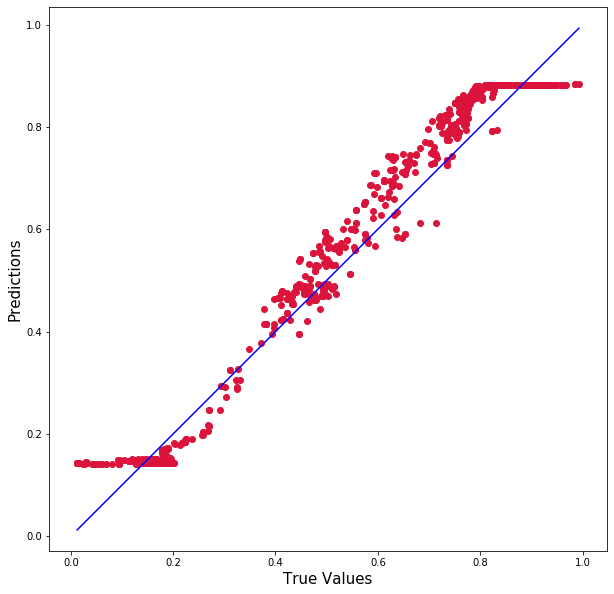

In [21]:
plt.figure(figsize=(10,10))

plt.scatter(Y_train, train_predict, c='crimson')

p1 = max(max(train_predict), max(Y_train))
p2 = min(min(train_predict), min(Y_train))

plt.plot([p1, p2], [p1, p2], 'b-')

plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

**Podsumowanie:**

Wykres punktowy rzeczywistych i przewidywanych wartości jest jedną z najbogatszych form wizualizacji danych.

W idealnym przypadku wszystkie punkty powinny znajdować się blisko linii ukośnej. Na powyższym wykresie widać, że punkty koncentrują się wokół ukośnej linii z niewielkimi wyjątkami na początku zestawu danych. Oznacza to dobre dopasowanie modelu.

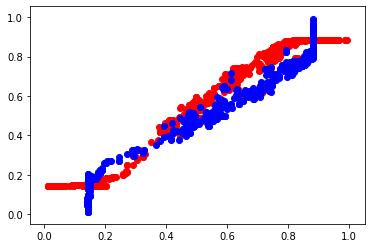

In [22]:
plt.scatter(Y_train,train_predict,color='red')
plt.scatter(train_predict,Y_train,color='blue')
plt.show()

#### Wykres przedstawiający funkcję kosztu
W głębokim uczeniu **loss** jest wartością, którą sieć neuronowa stara się zminimalizować: jest to odległość między wartością prawdziwą a przewidywaniami. Aby zminimalizować tę odległość, sieć neuronowa uczy się, dostosowując wagi i obciążenia w sposób, który zmniejsza straty. Dotyczy ona zbioru treningowego. Natomiast **val_loss** oznacza to samo, ale dotyczy zbioru testowego.

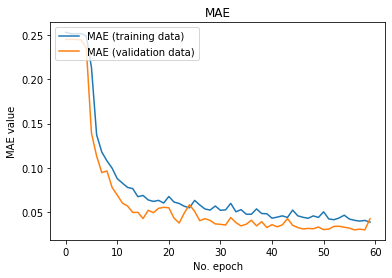

In [23]:
# MAE
plt.plot(history.history['loss'], label='MAE (training data)')
plt.plot(history.history['val_loss'], label='MAE (validation data)')
plt.title('MAE')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

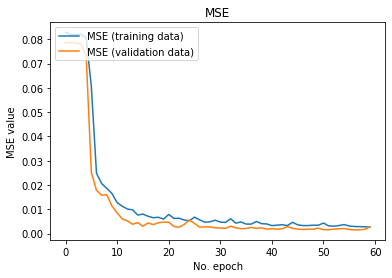

In [24]:
# MSE
plt.plot(history.history['mean_squared_error'], label='MSE (training data)')
plt.plot(history.history['val_mean_squared_error'], label='MSE (validation data)')
plt.title('MSE')
plt.ylabel('MSE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

# 2. Model wersja II

## 2.1. Wczytanie bazy

Wczytane zostają dane historyczne dotyczące notowań akcji spółki Amica, których zakres czasu obejmuje od 1998-09-08 do 2021-03-26. Przedsiębiorstwo Amica to polski producent sprzętu AGD. Firma działa od 1945 roku, a notowana na GPW jest od 1997 roku. 

Dane zostały pobrane z serwisu stooq.pl.

In [25]:
# katalog z plikiem powinien się znajdować w tym samym folderze, co obecnie odpalony plik
data = pd.read_csv('./dane/amc_d.csv')

## 2.2. Dzielenie danych na zbiór treningowy oraz testowy

Poniżej następuje podział danych na zbiór treningowy oraz testowy. Przyjęto podział odpowiednio na:
* 70% dla zbioru treningowego
* 30% dla zbioru testowego.

Cały zbiór danych zawiera 5889 wierszy i 6 kolumn.

**Zbiór treningowy (uczący)** - to zestaw danych, który używamy do nauki algorytmu. Na podstawie tych danych model uczy się odpowiednio klasyfikować, buduje wszelkie zależności. Przewiduje możliwe wyniki i podejmuje decyzje na podstawie przekazanych mu danych. 

**Zbiór testowy** - wykorzystywany, kiedy model został już zbudowany (dobrane hiperparametry itd.). Wtedy testuje się wszystko danymi z grupy testowej. Ważne, by dane testowe nie były wcześniej używane do uczenia czy walidacji modelu, ponieważ sprawdzamy, jak wybrany algorytm sprawdza się na danych, z którymi nigdy wcześniej nie miał do czynienia. 

In [26]:
# pierwsza liczba oznacza ilość wierszy, natomiast druga ilość kolumn w zbiorze danych
print(data.shape)

(5889, 6)


In [27]:
# zbiór treningowy (uczący)
ratio = 0.7  # współczynnik proporcji wymiarów (0.6 w stosunku do całego zbioru danych)
N = int(len(data)*ratio)   # liczba próbek na klasę
train_df, test_df = data[:N], data[N:]   # przypisanie próbek do zmiennych
print(train_df.shape)

(4122, 6)


In [28]:
# zbiór testowy
ratio = 0.3
N = int(len(data)*ratio)
test_df, val_df = test_df[:N], test_df[N:]
print(test_df.shape)

(1766, 6)


## 2.3. Podstawowe statystyki danych

Poniżej zaprezentowano podstawowe statystyki opisowe dla danych treningowych. 
* Średnie "Otwarcie" w badanym zakresie czasu wyniosło 25,66, natomiast "Zamknięcie" 25,69. 
* 75% obserwacji "Zamknięcia" jest poniżej 30,26, a 25% jest większa niż ta wartość
* Połowa wartości "Zamknięcia" ma wartość większą niż 21,92

In [29]:
# funkcja oblicza podsumowanie statystyk odnoszących się do kolumny DataFrame. 
# ta funkcja podaje wartości średnie, standardowe i odstęp międzykwartylowy.
train_df.describe()

,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Wolumen
count,4122.000000,4122.000000,4122.000000,4122.000000,4.121000e+03
mean,25.657604,25.974012,25.286211,25.690502,2.653247e+04
std,16.584416,16.729628,16.403979,16.596824,4.694825e+04
min,2.389900,2.455600,2.309500,2.375200,1.000000e+00
25%,15.639000,15.875500,15.348000,15.713000,4.390000e+03
50%,21.921000,22.142000,21.414000,21.921000,1.208500e+04
75%,30.238750,30.693000,29.818000,30.257000,2.977800e+04
max,100.740000,100.740000,99.494000,99.920000,1.057037e+06


In [30]:
# zapewnia obliczania w oknie kroczącym. 
# windows = rozmiar ruchomego okna, jest to liczba obserwacji użytych do obliczenia statystyki. 
# każde okno będzie miało stały rozmiar.
rolling = data.rolling(window=7)

In [31]:
# definiujemy nasz y, który chcemy przewidzieć; trenujemy model tylko na "Zamkniecie"
data_roll = pd.DataFrame()
data_roll['Zamkniecie']=train_df['Zamkniecie']

In [32]:
@widgets.interact_manual(lw=(1, 100))  #wstawia suwak do ręcznego wywoływania funkcji. Nie ma potrzeby uruchamiać za każdym razem kod, gdy zmieniamy wartość. 
def plot(lw):
  rolling = data.rolling(window=lw, center=True)
  data_roll = pd.DataFrame()
 
  data_roll['Zamkniecie']=data['Zamkniecie']
  data_roll['7 days rolling_mean(srednia kroczaca)']=data_roll['Zamkniecie'].rolling(lw, min_periods=1).mean()
  ax = data_roll.plot(style=['-', '--'], rot=90, figsize=(20, 10)) #odpowiada za rozmiar wykresu, oraz styl linii
  ax.lines[0].set_alpha(0.3)   #zmienia przeźroczystość linii wskazującej "Zamknięcie".

interactive(children=(IntSlider(value=50, description='lw', min=1), Button(description='Run Interact', style=B…

## 2.4. Przygotowanie danych do uczenia na sieci LSTM

W kodzie poniżej dane są przygotowywane do sieci LSTM, tak aby dotyczył tylko zmiennej przewidywanej w modelu, czyli "Zamknięcia". Rozmiary macierzy są dopasowywane, tak aby model mógł później działać na danych i je "obrabiać".

Rodzaj danych dla zmiennej "Zamknięcie" jest konwertowany na odpowiedni typ. Następnie tablica jest przekształcana, tak aby miała tylko jedną kolumnę wynikową. Funkcja **MinMaxScaler** skaluje wartości "Zamknięcia" tak, aby znajdowały się one w przedziale od 0 do 1, co przeciwdziała zaburzeniom modelu przez wartości odstające oraz umożliwia wiarygodną analizę. 

W następnym kroku, uporządkowane wcześniej dane są dzielone na zestawy do trenowania i testowania, tak aby nie zawrzeć danych użytych do trenowania w zbiorze testowym. Obliczane są długości tych zbiorów i indeksy podziału.


In [33]:
zmienna_przewidywana = "Zamkniecie"

def prepare_dataset_to_lstm(zmienna_przewidywana, train_df, ratio):
  dataset = train_df[zmienna_przewidywana].values #numpy.ndarray
  dataset = dataset.astype('float32') #zamiana typu na float
  dataset = np.reshape(dataset, (-1, 1)) #przekształcamy tablicę; wynikowa tablica ma tylko 1 kolumnę
  scaler = MinMaxScaler(feature_range=(0, 1)) #skalowanie zmiennych do postaci (0,1)
  dataset = scaler.fit_transform(dataset) # wszystkie inne wartości są liniowo skalowane między tymi wartościami

#dzielimy uporządkowany zestaw danych do trenowania i testowania. Oblicza index punktu podziału i rozdziela dane na zestawy szkoleniowe z test. obserwacji, których można użyć do trenowania modelu, pozostawiając pozostałe do przetestowania
  train_size = int(len(dataset) * ratio)
  test_size = len(dataset) - train_size
  train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

  return train, test, scaler

#uruchamiany tą funkcję z wyżej, przygotowanie modelu pod LSTM
train, test, scaler = prepare_dataset_to_lstm(zmienna_przewidywana, train_df, ratio=0.8) #scaler - skaluje dane do zakresu 0, 1 (tak zwana normalizacja)

Poniższa funkcja tworzy zbiór danych do sieci **LSTM**. Dla zakresu o 2 mniejszego niż zbiór danych wejściowych, aby pętla nie wyszła poza zasięg, przygotowywane są zbiory X i Y. Zbiór X to macierz tworzona z "zakładką" 1 kroku czasowego. Zbiór Y to lista wartości. Wykorzystując tę funkcję, tworzone są zbiory testowy oraz treningowy z zachowaniem odpowiednich wymiarów macierzy.

In [34]:
# look_back- liczba poprzednich kroków czasowych, które mają być użyte jako zmienne wejściowe do przewidywania następnego okresu czasu, w tym przypadku domyślnie 1.
# scaler- skaluje dane do zakresu 0,1 (normalizacja)
# tworzenie back(ów); konwertujemy tablicę wartości na macierz zestawu danych
def create_dataset_lstm(dataset, look_back=1):   #look_back - wielkość kroku z którą testujemy dataset
    X, Y = [], []
    for i in range(len(dataset)-look_back-1): # żeby nie wyszło poza zasięg
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

#używamy funkcji by przygotować zestaw i przetestować zestawy danych do modelowania.
look_back = 20 #liczba probek ktora pobieramy, minimalnie jedna próbka, maksymalnie tyle, ile ma ciąg elementów
X_train, Y_train = create_dataset_lstm(train, look_back)
X_test, Y_test = create_dataset_lstm(test, look_back)

#Zmienia kształt wejścia na próbki, kroki czasowe, cechy,
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

## 2.5. Uczenie modelu

Poniższa funkcja służy do uczenia modelu sieci LSTM. Tworzony jest model **sekwencyjny**. Umożliwia on tworzenie modeli warstwa po warstwie. Jest jednak ograniczony, ponieważ nie pozwala na tworzenie modeli, które współdzielą warstwy lub mają wiele wejść lub wyjść. Tworzony model sieci LSTM ma **jedno wejście** w warstwie wejściowej i **20 neuronów** w warstwie ukrytej. 
W modelu zastosowano następujące paramtery:
* Dropout = 0.1 
* Dense = 15

**Droput** - to prosta, ale zarazem bardzo skuteczna technika przeciwdziałania overfittingowi (przeuczeniu). Polega na losowym usuwaniu z sieci (z warstw wewnętrznych, czasami również wejściowych) pojedynczych neuronów w trakcie uczenia. Najczęściej stosuje się 0.5, ale parametr można dowolnie dostrajać.

**Dense** - to jedyna rzeczywista warstwa sieciowa w modelu, która przekazuje wszystkie sygnały wyjściowe z poprzedniej warstwy do wszystkich swoich neuronów, a każdy neuron dostarcza jedno wyjście do następnej warstwy.

Model tworzony jest ze wskazaniem, że jakość uczenia będzie pokazywana w **Mean Squared Error**, czyli w błędzie średniokwadratowym. Optymalizator to algorytm **Adam**.  Jest to algorytm używany do zmiany atrybutów sieci neuronowej, takich jak wagi i szybkość uczenia się, w celu zmniejszenia strat. Adam łączy najlepsze właściwości algorytmów AdaGrad i RMSProp, aby zapewnić algorytm optymalizacji, który radzi sobie nawet z rzadkimi problemami.

In [35]:
#Tworzymy i dopasowujemy model LSTM (zmiana batch_size). W poniższym modelu jest jedno wejście w warstwie wejściowej
# i 20 neuronów w warstwie ukrytej. Warstwa wyjściowa przewiduje wartości
def lstm_model(X_train, Y_train, X_test, Y_test, batch_size=20):
  model = Sequential()  #liniowy stos warstw
  model.add(LSTM(20, input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(Dropout(0.1)) 
  model.add(Dense(15)) 
# definiujemy w czym będziemy wyrażać naszą jakość uczenia
  model.compile(loss='mean_squared_error', optimizer='adam') #definiujemy w czym będziemy wyrażać naszą jakośc uczenia

# epochs - Funkcja aktywacji powtarzana jest 5 razy
  history = model.fit(X_train, Y_train, epochs=5, batch_size=10, validation_data=(X_test, Y_test), 
                      # przerwij trenowanie, gdy monitorowana metryka przestanie się poprawiać
                      callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False) 
  return model



## 2.6. Ewaluacja modelu

Kolejna część to ewaluacja modelu. Poniższa funkcja wykonuje prognozy dla zbioru treningowego i testowego. 
Następnie oblicza błędy prognozy:
* **Mean Squared Error** - Błąd Średniokwadratowy, który jest wartością oczekiwaną kwadratu „błędu”, czyli różnicy między estymatorem a wartością estymowaną. 
* **Mean Absolute Error** - Średni Błąd Bezwzględny, który oblicza się jako średnią wartości bezwzględnych błędu prognozy. Jeśli wartość ta równa się 0 (zero), dopasowanie (prognoza) jest doskonałe.

Obliczenie błędów prognoz daje obraz jakości modelu.  

In [36]:
#ewaluacja modelu
def evaluation_model(model,X_train, X_test, Y_train, testing=False):
  dataset = train_df[zmienna_przewidywana].values #numpy.ndarray
  dataset = dataset.astype('float32') #zamian typu na float
  dataset = np.reshape(dataset, (-1, 1))  # zmienia shape na odwrotny (odwrócenie macierzy) nie w sposób ciągły (1 pod 2)
  scaler = MinMaxScaler(feature_range=(0, 1))
  dataset = scaler.fit_transform(dataset)
  
#wykonaj prognozy
  train_predict = model.predict(X_train)
  test_predict = model.predict(X_test)

#odwróć prognozy, przy obliczaniu błędu przekonwertujemy dane na tą samą jednostkę.  
  train_predict = scaler.inverse_transform(train_predict)
  Y_train = scaler.inverse_transform([Y_train])

#oblicz średni kwadrat błędu
  _mean_absolute_error = mean_absolute_error(Y_train[0], train_predict[:,0])   #jak mamy listę 13 elementów, to wstawiając [3,:] pobierze od 3 do 13 elementu
  _mean_squared_error = np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0]))
  print('Train Mean Absolute Error:', _mean_absolute_error)
  print('Train Root Mean Squared Error:',_mean_squared_error)
  if testing:
    return Y_train, train_predict, _mean_absolute_error, _mean_squared_error
  return Y_train, train_predict



In [37]:
def a():
    return 1, 2, (10, 20)

x,y, error = a()
print(a())
print(x,y, error)

# 1 to nasz x- Y_train, 2 nasz y- train_predict  a (10-_mean_absolute_error, 20- _mean_squared_error) nasze dołożone errory (patrz analogicznie linijkę wyżej)

(1, 2, (10, 20))
1 2 (10, 20)


In [38]:
#Model się uczy!
history = lstm_model(X_train, Y_train, X_test, Y_test, batch_size=10)

# loss to funkcja straty na zbiorze treningowym (uczącym)
# val_loss to funkcja straty na zbiorze walidacyjnym (im mniejsza tym lepiej)

# widzimy że z każdą kolejną epoką te dwa błędy są coraz mniejsze- zatem model dobrze się uczy. 
# im mniejsze błędy (bliższe 0- tym lepiej)

Epoch 1/5
328/328 [==============================] - 2s 3ms/step - loss: 0.0490 - val_loss: 0.0128
Epoch 2/5
328/328 [==============================] - 1s 3ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 3/5
328/328 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 4/5
328/328 [==============================] - 2s 6ms/step - loss: 0.0018 - val_loss: 0.0026
Epoch 5/5
328/328 [==============================] - 2s 5ms/step - loss: 0.0015 - val_loss: 0.0034


Powyżej zastosowano stworzoną wcześniej funkcję modelu LSTM. Widać, że z każdą epoką model uczy się coraz lepiej. Wartości błędów są ogólnie coraz mniejsze, podobnie jak straty.

## 2.7. Zapisanie modelu

Stworzony model zostaje zapisany, aby w kolejnych krokach móc go wykrozystać do generalizacji na nowych danych.

In [39]:
# zapisujemy model sieci neuronowej w formacie JSON
model_json = history.to_json()  #zapisanie modelu history do JSON
with open("model.json", "w") as json_file:  #utwórz plik model.json w trybie edycji i zatrzymaj w zmiennej json_file
    json_file.write(model_json)
# zapisanie wagi z modelu za pomocą funkcji save.weights. 
history.save_weights("model.h5")  #wagi są zapisywane w pliku model.h5 w katalogu lokalnym.
print("Saved model to disk")  #komentarz udanej operacji

Saved model to disk


Poniżej uruchomiona zostaje funkcja ewaluacji modelu, aby sprawdzić jego jakość. Widać, że błędy są dość niskie.

In [40]:
evaluation_model(history,X_train, X_test, Y_train)

Train Mean Absolute Error: 3.2092495197768454
Train Root Mean Squared Error: 3.48973584143159


(array([[48.9640034 , 49.69400143, 50.79099854, ..., 37.27199966,
         37.08900014, 37.38099994]]),
 array([[49.665424, 49.86274 , 50.63606 , ..., 50.1748  , 53.290543,
         51.013172],
        [49.86653 , 49.958992, 50.63507 , ..., 50.35547 , 53.594425,
         50.97416 ],
        [49.710625, 49.896305, 50.6652  , ..., 50.266407, 53.345577,
         51.023384],
        ...,
        [39.230137, 39.194324, 39.551765, ..., 39.53838 , 40.3825  ,
         39.271782],
        [39.311703, 39.354095, 39.57089 , ..., 39.562233, 40.497616,
         39.18658 ],
        [39.34604 , 39.36726 , 39.64471 , ..., 39.644234, 40.48938 ,
         39.279705]], dtype=float32))

In [41]:
Y_train, train_predict = evaluation_model(history,X_train, X_test, Y_train)

Train Mean Absolute Error: 3.2092495197768454
Train Root Mean Squared Error: 3.48973584143159


**Podsumowanie:**

Powyższe błędy pomagają określić jakość tworzonego modelu. 

* **Średni błąd bezwzględny (MAE - Mean Absolute Error)** wynosi 3,21. Informuje on o ile średnio w okresie prognoz, będzie wynosić odchylenie od wartości rzeczywistej. Czyli, krótko mówiąc, prognoza jest obarczona błędem miarowym wynoszącym 3,21.

* **Średni błąd kwadratowy (MSE - Mean Squared Error)** wynosi 3,49. Ten wskaźnik również mierzy średnią wielkość błędu. Jest to pierwiastek kwadratowy średniej kwadratów różnic między prognozą a rzeczywistą obserwacją. Oznacza, że rzeczywiste relacje zmiennej prognozowanej odchylają się średnio o 3,18 od obliczonych prognoz. 

Zarówno MAE, jak i MSE wyrażają średni błąd prognozowania modelu w jednostkach interesującej nas zmiennej. 
Jeśli chodzi o różnice między tymi dwiema zmiennymi, to w przypadku MSE, ponieważ błędy są podnoszone do kwadratu, zanim zostaną uśrednione, RMSE (pierwiastek z MSE) nadaje stosunkowo dużą wagę dużym błędom. Oznacza to, że MSE powinien być bardziej przydatny, gdy duże błędy są szczególnie niepożądane.


## 2.8. Wizualizacja wyników

In [42]:
def visualization(Y_train, train_predict):
  N = len(Y_train[0]) 
  aa=[x for x in range(N)]  # N oznacza liczbę cech w punkcie danych
  plt.figure(figsize=(8,4))
  plt.plot(aa, Y_train[0], marker='.', label="actual") # gdy . zmienimy na * to będziemy mieli zamiast . -> *
  plt.plot(aa, train_predict[:,0], 'r', label="prediction")
  # plt.tick_params(left=False, labelleft=True) #remove ticks
  plt.tight_layout()  # dostosuj dopełnienie między polamy pomocniczymi i wokół nich
  sns.despine(top=True) # usuwamy grzbiet
  plt.subplots_adjust(left=0.07)  # położenie lewej krawędzi wykresu
  plt.title(" prediction")
  plt.xlabel('Time step', size=15)  # rozmiar czcionki dla time step 15
  plt.legend(fontsize=15)  # rozmiar czcionki elementów legendy
  plt.show();  # uruchamiamy pętle zdarzeń, wyszukujemy wszystkie aktywne obiekty figur i otwieramy jedno lub więcej inteaktywnych okien.


#### Podsumowanie:
Na poniższym wykresie widać dane rzeczywiste i prognozowane. Można zauważyć, że model świetnie odwzorowuje prawdziwe wartości, a dopasowanie jest bardzo dobre. Odchylenia są małe, a linie przedstawiające wartości prawdziwe i przewidywane nachodzą na siebie. Wartości przewidziane przez nauczony model są bardzo bliskie tym faktycznym.

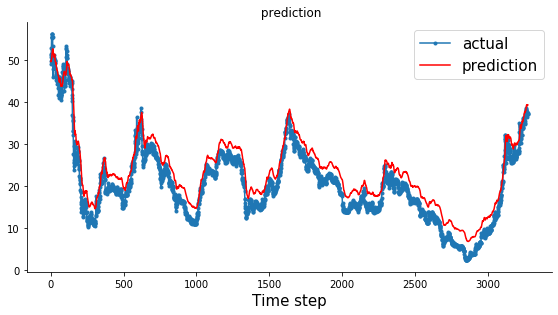

In [43]:
# Na wykresie dane nie są znormalizowane
visualization(Y_train, train_predict)

## 2.9. Zmiana wielkości batch

**Batch** to zmienna, która określa rozmiar partii to termin używany w uczeniu maszynowym i odnosi się do liczby przykładów szkoleniowych wykorzystywanych w jednej iteracji. Przykład (sample) to jeden wiersz danych. Batch można traktować jako iterację w pętli for na jednej lub kilku próbkach i tworzeniu prognoz.

Aby zobaczyć jak zachowują się wyniki i jaki wpływ ma na nie zmienna **batch** tworzona jest pętla, która trenuje dane dla różnych wielkości **batch**. Wyniki prezentowane są wraz ze wskazaniem błędów MSA oraz MSE, dzięki którym widać jak wygląda proces uczenia się w zależności od tej zmiennej. 

In [44]:
# <odswiezam dane>, gdyz wymiary danych testowych i treningowych przestaja sie zgadac
train, test, scaler = prepare_dataset_to_lstm(zmienna_przewidywana, train_df, ratio=0.8)

def create_dataset_lstm(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 3 #liczba probek ktora pobieramy, minimalnie jedna probka, maksymalnie tyle, ile ma ciag elementow
X_train, Y_train = create_dataset_lstm(train, look_back)
X_test, Y_test = create_dataset_lstm(test, look_back)
print(X_test)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

[[0.3521131  0.35251293 0.35775152]
 [0.35251293 0.35775152 0.35026777]
 [0.35775152 0.35026777 0.3472538 ]
 ...
 [0.91375256 0.9017272  0.9076835 ]
 [0.9017272  0.9076835  0.9329027 ]
 [0.9076835  0.9329027  0.90602267]]


In [45]:
# wielkosc batchu [10, 20, 50]
batch_start, batch_end = 30, 40 # od do
look_backs = [3,10,30] # takie look backi sprawdzamy i potem do nich mozemy wykresy zrobic


error_look_back = {}
for look_back in look_backs:
  MAEs = []
  MSEs = []
  Y_trains = []
  train_predicts = []

  X_train, Y_train = create_dataset_lstm(train, look_back)
  X_test, Y_test = create_dataset_lstm(test, look_back)
  X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
  X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
  for batch in range(batch_start, batch_end):
    print(f'-------------------------------{batch}--------------------------')
    history = lstm_model(X_train, Y_train, X_test, Y_test, batch_size=batch)
    tmp_Y_train, tmp_train_predict, MAE, MSE  = evaluation_model(history,X_train, X_test, Y_train, testing=True)
    
    MAEs.append(MAE)
    MSEs.append(MSE)
    Y_trains.append(tmp_Y_train)
    train_predicts.append(tmp_train_predict)
  error_look_back[look_back] = {"MAE":MAEs, "MSE":MSEs, "Y_trains": Y_trains, "train_predicts": train_predicts}



-------------------------------30--------------------------
Epoch 1/5
330/330 [==============================] - 2s 2ms/step - loss: 0.0531 - val_loss: 0.0829
Epoch 2/5
330/330 [==============================] - 2s 5ms/step - loss: 0.0108 - val_loss: 0.0299
Epoch 3/5
330/330 [==============================] - 1s 2ms/step - loss: 0.0041 - val_loss: 0.0033
Epoch 4/5
330/330 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 5.4049e-04
Epoch 5/5
330/330 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0012
Train Mean Absolute Error: 1.038083663859363
Train Root Mean Squared Error: 1.3465593797226423
-------------------------------31--------------------------
Epoch 1/5
330/330 [==============================] - 2s 2ms/step - loss: 0.0555 - val_loss: 0.0971
Epoch 2/5
330/330 [==============================] - 1s 4ms/step - loss: 0.0131 - val_loss: 0.0485
Epoch 3/5
330/330 [==============================] - 2s 5ms/step - loss: 0.0065 - val_lo

329/329 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 4/5
329/329 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 5/5
329/329 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0013
Train Mean Absolute Error: 2.1660631225372704
Train Root Mean Squared Error: 2.4065160928435088
-------------------------------33--------------------------
Epoch 1/5
329/329 [==============================] - 2s 2ms/step - loss: 0.0495 - val_loss: 0.0229
Epoch 2/5
329/329 [==============================] - 2s 5ms/step - loss: 0.0037 - val_loss: 0.0022
Epoch 3/5
329/329 [==============================] - 1s 4ms/step - loss: 0.0017 - val_loss: 8.4246e-04
Epoch 4/5
329/329 [==============================] - 1s 3ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 5/5
329/329 [==============================] - 1s 3ms/step - loss: 0.0013 - val_loss: 0.0015
Train Mean Absolute Error: 1.634336908050216
Train Root Me

Epoch 1/5
327/327 [==============================] - 2s 2ms/step - loss: 0.0388 - val_loss: 0.0109
Epoch 2/5
327/327 [==============================] - 1s 3ms/step - loss: 0.0032 - val_loss: 0.0054
Epoch 3/5
327/327 [==============================] - 1s 3ms/step - loss: 0.0025 - val_loss: 0.0064
Epoch 4/5
327/327 [==============================] - 1s 4ms/step - loss: 0.0022 - val_loss: 0.0099
Epoch 5/5
327/327 [==============================] - 2s 6ms/step - loss: 0.0018 - val_loss: 0.0154
Train Mean Absolute Error: 4.093843578208514
Train Root Mean Squared Error: 4.348256092152377
-------------------------------36--------------------------
Epoch 1/5
327/327 [==============================] - 2s 3ms/step - loss: 0.0368 - val_loss: 0.0100
Epoch 2/5
327/327 [==============================] - 1s 2ms/step - loss: 0.0032 - val_loss: 0.0080
Epoch 3/5
327/327 [==============================] - 2s 6ms/step - loss: 0.0026 - val_loss: 0.0120
Epoch 4/5
327/327 [==============================] - 0

**Można zauważyć, że wraz ze wzrostem wielkości batch'a, pogorszają się wyniki MAE i MSE. Powinny one idealnie równać się zero, więc generalnie im mniejsze ich wartości, tym model uważamy za lepszy.**

**Również w przypadku zwiększania wielkości lookback wartości błędów pogorszają się.**

In [46]:
# wyświetlenie liczby kolumn i wierszy
train_predict.shape

(3276, 15)

In [47]:
error_look_back[3]["MSE"]

[1.3465593797226423,
 1.589607566053304,
 1.1807987154987076,
 1.3071597370261563,
 1.3396296085151502,
 1.1147392288557312,
 1.4494543407844023,
 1.4115254058080502,
 1.31834145942507,
 1.4911944746025632]

In [48]:
error_look_back[3]["MAE"]

[1.038083663859363,
 1.3079973268528766,
 0.882588449282858,
 1.045754512320149,
 1.0744306925474774,
 0.8057984530058977,
 1.1777655584063,
 1.0914562564626717,
 1.0172120897865324,
 1.2399644161372199]

In [49]:
error_look_back[10]["MSE"]

[2.108314715871338,
 2.1630338195076675,
 2.4065160928435088,
 2.055175877884873,
 2.52002519852966,
 2.1845276518321257,
 2.525665069554295,
 2.3760924459504067,
 2.1035003381139292,
 2.191445323019596]

In [50]:
error_look_back[10]["MAE"]

[1.7705276305532982,
 1.836379217277109,
 2.1660631225372704,
 1.634336908050216,
 2.289102475114976,
 1.8560176832849389,
 2.272680238149422,
 2.096537399359501,
 1.7352068149211666,
 1.8655091444943874]

In [51]:
error_look_back[30]["MSE"]

[4.254432066614605,
 4.939006510369758,
 4.165547562063841,
 4.546368877512047,
 4.454813705587037,
 4.348256092152377,
 4.077318958838747,
 4.496629811119908,
 3.58919134511267,
 3.7046452793601143]

In [52]:
error_look_back[30]["MAE"]

[4.0201105747419525,
 4.697867475011229,
 3.859253304396904,
 4.314505172012989,
 4.192874504476061,
 4.093843578208514,
 3.7682902619270924,
 4.273915004356935,
 3.236866009649786,
 3.437197865303983]

In [53]:
# wyświetlenie i posortowanie MSE
MSEs.sort()
print(MSEs)

[3.58919134511267, 3.7046452793601143, 4.077318958838747, 4.165547562063841, 4.254432066614605, 4.348256092152377, 4.454813705587037, 4.496629811119908, 4.546368877512047, 4.939006510369758]


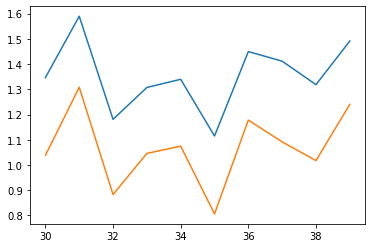

In [54]:
# wykres kreśli linię MSE, oraz MAE
look_back_to_check = 3
sns.lineplot(x=[a for a in range(batch_start, batch_end)], y=error_look_back[look_back_to_check]["MSE"])
sns.lineplot(x=[a for a in range(batch_start, batch_end)], y=error_look_back[look_back_to_check]["MAE"])

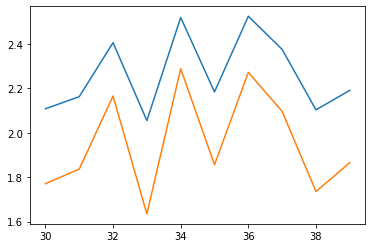

In [55]:
look_back_to_check = 10
sns.lineplot(x=[a for a in range(batch_start, batch_end)], y=error_look_back[look_back_to_check]["MSE"])
sns.lineplot(x=[a for a in range(batch_start, batch_end)], y=error_look_back[look_back_to_check]["MAE"])

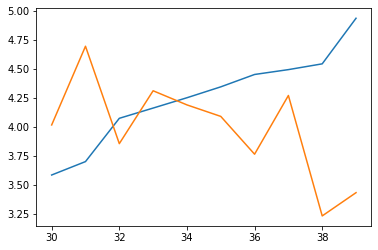

In [56]:
look_back_to_check = 30
sns.lineplot(x=[a for a in range(batch_start, batch_end)], y=error_look_back[look_back_to_check]["MSE"])
sns.lineplot(x=[a for a in range(batch_start, batch_end)], y=error_look_back[look_back_to_check]["MAE"])

**Podsumowanie:**
    
Ogólnie, stwierdzić można, że dla wszystkich sprawdzanych lookbacków, wraz z wielkością batch błędy rosną, a tym samym pogarsza się jakość modelu.

Powyżej widać błędy MSE i MAE dla sprawdzanych lookbacków (3, 10 i 30) w podziale na batche (30 do 40). Dla wielkości batch można zauważyć, że im dalej, tym błędy prognoz są generalnie większe. Wykresy natomiast przedstawiają błędy MSE oraz MAE dla sprawdzanych lookbacków 3, 10 i 30. Można stwierdzić, że wraz ze wzrostem batch, zwiększają się błędy, co oznacza, że wyniki uczenia są coraz gorsze.

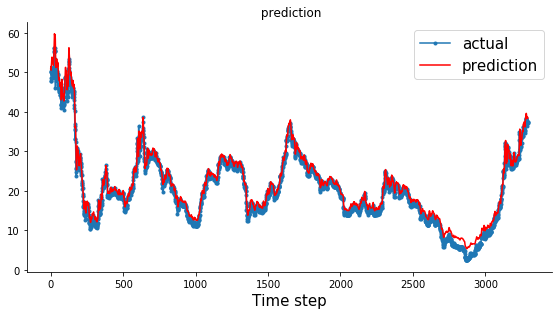

In [57]:
batch_index = 6 # to znaczy batch_start (bedzie tyle indexow ile jest od batch_start do batch_end)
look_back_to_check = 3 
visualization(Y_train = error_look_back[look_back_to_check]["Y_trains"][batch_index], train_predict = error_look_back[look_back_to_check]["train_predicts"][batch_index])

In [58]:
error_look_back[3]["Y_trains"][0]

array([[48.60100154, 47.86900054, 47.86900054, ..., 37.08900014,
        37.38099994, 37.34400176]])

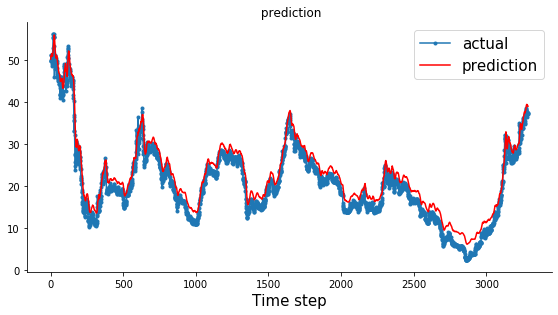

In [59]:
batch_index = 6 
look_back_to_check = 10
visualization(Y_train = error_look_back[look_back_to_check]["Y_trains"][batch_index], train_predict = error_look_back[look_back_to_check]["train_predicts"][batch_index])

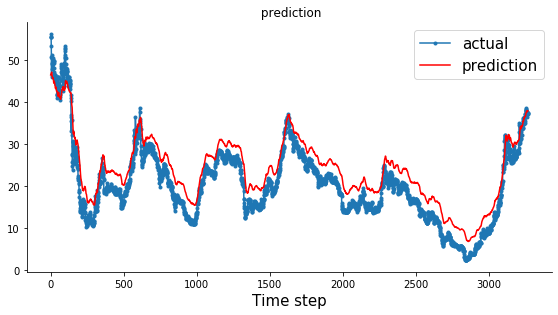

In [60]:
batch_index = 6 
look_back_to_check = 30
visualization(Y_train = error_look_back[look_back_to_check]["Y_trains"][batch_index], train_predict = error_look_back[look_back_to_check]["train_predicts"][batch_index])

**Podsumowanie:**

Najlepsze dopasowanie danych rzeczywistych do przewidywanych widoczne jest dla lookbacka = 3 (wykres 1 powyżej). Jest nieco lepsze niż w przypadku tworzonego modelu, gdzie lookback = 1. Na powyższych wykresach dla sprawdzanych lookbacków 3, 10 oraz 30 widać także, że im jest on większy tym gorsze dopasowanie danych. Podobnie na wykresach przedstawiających błędy  MAE i MSE dla danych lookbacków widać pogorszanie się ich wartości. 

# 2.1. Generalizacja modelu

Wczytywany jest model sieci LSTM, który wcześniej został zbudowany.

In [61]:
# wczytanie modelu z poprzednich zajec
json_file = open('./model.json', 'r')
loaded_model_json = json_file.read()


In [62]:
# json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("./model.h5")
print("Loaded model from disk")

Loaded model from disk


### Generalizacja I

In [63]:
data = pd.read_csv('./dane/ago_d.csv')#wczytanie pliku

Poniżej wywoływane są zdefiniowane wcześniej funkcje przygotowujące dane do modelu sieci LSTM. Z nowo załadowanych danych tworzone są zestawy treningowe i testowe. 

In [64]:
zmienna_przewidywana = "Zamkniecie"


def prepare_dataset_to_lstm(zmienna_przewidywana, train_df, ratio):
  dataset = train_df[zmienna_przewidywana].values #numpy.ndarray
  dataset = dataset.astype('float32') #zamian typu na float
  dataset = np.reshape(dataset, (-1, 1))
  scaler = MinMaxScaler(feature_range=(0, 1)) #skalowanie zmiennych
  dataset = scaler.fit_transform(dataset)
  train_size = int(len(dataset) * ratio)
  test_size = len(dataset) - train_size
  train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

  return train, test, scaler

In [65]:
train, test, scaler = prepare_dataset_to_lstm(zmienna_przewidywana, data, ratio=0.5)


def create_dataset_lstm(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 20 #liczba probek ktora pobieramy, minimalnie jedna probka, maksymalnie tyle, ile ma ciag elementow
X_train, Y_train = create_dataset_lstm(train, look_back)
X_test, Y_test = create_dataset_lstm(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [66]:
#ewaluacja modelu
def evaluation_model(model,X_train, X_test, Y_train):
  dataset = data[zmienna_przewidywana].values #numpy.ndarray
  dataset = dataset.astype('float32') #zamian typu na float
  dataset = np.reshape(dataset, (-1, 1))
  scaler = MinMaxScaler(feature_range=(0, 1))
  dataset = scaler.fit_transform(dataset)
  
  train_predict = model.predict(X_train)
  test_predict = model.predict(X_test)
  # invert predictions
  
  train_predict = scaler.inverse_transform(train_predict)
  Y_train = scaler.inverse_transform([Y_train])

  print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
  print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))

  return Y_train, train_predict

#### Poniżej sprawdzane jest, jak model działa na nowych danych. Wyniki porównywane są z wielkością batch. Jak widać wielkość batch nie wpływa na błędy prognozy.

In [67]:
for batch in [10, 20, 50]:
  
  evaluation_model(loaded_model,X_train, X_test, Y_train)
  print(evaluation_model)


Train Mean Absolute Error: 4.074827722346257
Train Root Mean Squared Error: 4.8996853346343725
<function evaluation_model at 0x00000230173339D8>
Train Mean Absolute Error: 4.074827722346257
Train Root Mean Squared Error: 4.8996853346343725
<function evaluation_model at 0x00000230173339D8>
Train Mean Absolute Error: 4.074827722346257
Train Root Mean Squared Error: 4.8996853346343725
<function evaluation_model at 0x00000230173339D8>


In [68]:
Y_train, train_predict = evaluation_model(loaded_model,X_train, X_test, Y_train)

Train Mean Absolute Error: 4.074827722346257
Train Root Mean Squared Error: 4.8996853346343725


In [69]:
def visualization(Y_train, train_predict):
  N = len(Y_train[0])
  aa=[x for x in range(N)]
  plt.figure(figsize=(8,4))
  plt.plot(aa, Y_train[0], marker='.', label="actual")
  plt.plot(aa, train_predict[:,0], 'r', label="prediction")
  # plt.tick_params(left=False, labelleft=True) #remove ticks
  plt.tight_layout()
  sns.despine(top=True)
  plt.subplots_adjust(left=0.07)
  plt.title(" prediction")
  plt.xlabel('Time step', size=15)
  plt.legend(fontsize=15)
  plt.show();


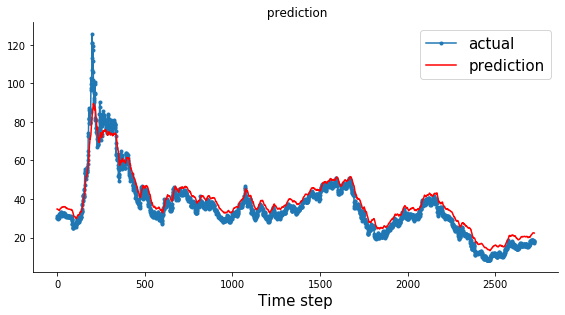

In [70]:
visualization(Y_train, train_predict)

**Podsumowanie:**

Jak widać powyżej model działa bardzo dobrze na nowych danych. Wartości przewidywane mają bardzo znikome odchylenia od wartości rzeczywistych, co oznacza, że model dobrze odwzorowuje. Dla nowych danych MAE wynosi 4,08, natomiast MSE 4,9. Dla pierwotnych danych błędy były nieco mniejsze i wymosiły odpowiednio: MAE: 3,21 oraz MSE: 3,49.

Wcześniejszy model dotyczył akcji spółki Amica. Generalizacja została przeprowadzona na danych dotyczących akcji spółki Agora.

### Generalizacja II

In [71]:
data2 = pd.read_csv('./dane/ska_d.csv')#wczytanie pliku

In [72]:
train2, test2, scaler2 = prepare_dataset_to_lstm(zmienna_przewidywana, data2, ratio=0.5)

In [73]:
look_back = 20 #liczba probek ktora pobieramy, minimalnie jedna probka, maksymalnie tyle, ile ma ciag elementow
X_train2, Y_train2 = create_dataset_lstm(train2, look_back)
X_test2, Y_test2 = create_dataset_lstm(test2, look_back)

# reshape input to be [samples, time steps, features]
X_train2 = np.reshape(X_train2, (X_train2.shape[0], 1, X_train2.shape[1]))
X_test2 = np.reshape(X_test2, (X_test2.shape[0], 1, X_test2.shape[1]))

In [74]:
Y_train2, train_predict2 = evaluation_model(loaded_model,X_train2, X_test2, Y_train2)

Train Mean Absolute Error: 4.367245352586072
Train Root Mean Squared Error: 4.5441394898964305


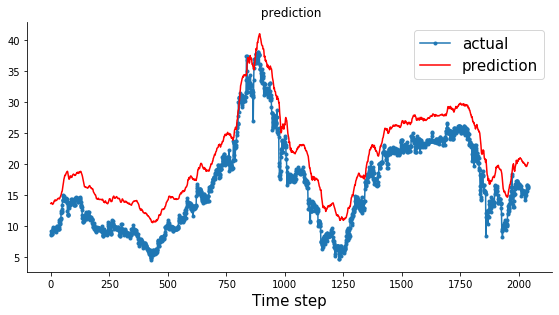

In [75]:
visualization(Y_train2, train_predict2)

**Podsumowanie:**
    
Wykonano także generalizację dla danych o akcjach spółki Fabryka Farb i Lakierów Śnieżka. W tym przypaku model również ma dobrą zdolność do generalizacji. Rozbieżności między wartościami rzeczywistymi a prognozowanymi nie są duże. Średni całkowity błąd MAE wyniósł 4,37, natomiast średni kwadratowy błąd MSE 4,54. 